In [22]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

def clean_string(my_list,string):
    data =[]
    for item in my_list:
        a = re.sub(string,'',item)
        data.append(a)
    return data

df = pd.read_csv('.\FIFAPlayersData.csv')

#~~~~DATA WRANGLING~~~~~~~~~
#deleting old indexes
del df['Unnamed: 0']

#Renaming columns
df.rename(columns={"col-pi": "Player ID", "col-tt": "Total Stats","col-gu":"Growth","col-le":"Loan",
                   "col-pac":"Pace","col-sho":"Shooting","col-vl":"Value","col-bp":"Best Position",
                   "col-wg":"Wage","col-def":"Defending","col-phy":"Physical","col-ae":"Age","col-pas":"Passing",
                   "col-dri":"Dribbling","col-oa":"Overall","col-pt":"Potential"},inplace=True)

#Dropping duplicates
df.drop_duplicates(subset ="Player ID",keep = False, inplace = True)

#Reordering columns
df = df[['Player ID','Name','Age','Best Position','Overall','Potential','Growth'   ,'Team','Value','Wage',
         'Contract' ,'Loan','Total Stats','Passing','Shooting','Pace'  ,'Defending','Physical','Dribbling']]

#Cleaning wages and values, turning into int
df['Wage'] = df['Wage'].apply(lambda x: re.sub('€','',x))
df['Wage'] = df['Wage'].apply(lambda x: re.sub('K','000',x))
df['Value'] = df['Value'].apply(lambda x: re.sub('€','',x))
df['Value'] = df['Value'].apply(lambda x : re.sub('M','00000',x) if (('M' in x) and ('.' in x))else x)
df['Value'] = df['Value'].apply(lambda x : re.sub('[.]','',x))
df['Value'] = df['Value'].apply(lambda x : re.sub('M','000000',x))
df['Value'] = df['Value'].apply(lambda x : re.sub('K','000',x))

df['Wage'] = df['Wage'].astype(int)
df['Value'] = df['Value'].astype(int)

#Filter players that no longer play, with contract ending earlier than 2021. 
df[['Contract Start','Contract End']] = df['Contract'].str.split('~',expand=True)

#Filter zeros in values/Free agents and players over 40 a players under 70 of overall
df = df[df['Value']>0]
df = df[df['Age']<40]
df = df[df['Overall']>70]

#Filter players not playing anymore
df['Contract End'] = df['Contract End'].apply(lambda x: "2021" if x is None else x)
df['Contract End'] = df['Contract End'].astype(int)
df = df[df['Contract End']>2020]


df.head()

,Player ID,Name,Age,Best Position,Overall,Potential,Growth,Team,Value,Wage,...,Loan,Total Stats,Passing,Shooting,Pace,Defending,Physical,Dribbling,Contract Start,Contract End
59,238074,R. James,20,RB,80,86,6,Chelsea,30500000,61000,...,NaN,2076,77,58,80,76,79,77,2017,2025
61,240950,Pedro Gonçalves,22,CAM,79,87,8,Sporting CP,39500000,16000,...,NaN,2021,78,75,74,56,57,83,2020,2025
62,253004,Ansu Fati,17,LW,76,90,14,FC Barcelona,17000000,24000,...,NaN,1817,68,74,88,29,53,79,2018,2022
63,237995,D. Lainez,20,CAM,74,84,10,Real Betis,9500000,15000,...,NaN,1873,69,64,79,49,55,80,2019,2024
64,231943,Richarlison,23,ST,81,87,6,Everton,41000000,90000,...,NaN,2114,73,79,83,53,80,83,2018,2024


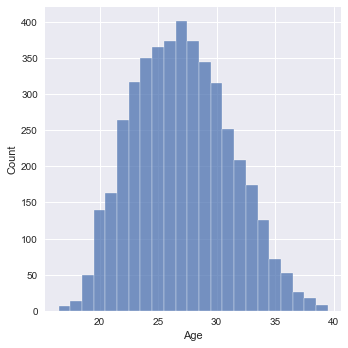

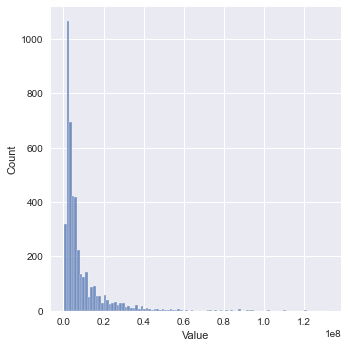

In [440]:
#~~~~DATA EXPLORATION
age_dist = sns.displot(df,x="Age",discrete=True)
value_dist = sns.displot(df,x="Value", bins=100)
overall_dist = sns.displot(df,x="Overall",bins = 20)
value_vs_wages_scat=sns.displot(data=df, x="Value", y="Wage")
overall_vs_value_scat = sns.displot(data=df, x="Overall", y="Value")
sns.displot(data=df, x="Potential", y="Value")

#Getting a sorted boxplot Value vs Age
grouped = df.groupby('Age')
sorted_averages = (
    pd.DataFrame({col: vals['Value'] for col, vals in grouped})
    .mean()
    .sort_values(ascending=False)
)
boxp_val_vs_age = sns.boxplot(x="Age", y="Value", data=df,order=sorted_averages.index)

#Getting a sorted boxplot Value vs Best Position
grouped = df.groupby('Best Position')
sorted_averages = (
    pd.DataFrame({col: vals['Value'] for col, vals in grouped})
    .mean()
    .sort_values(ascending=False)
)
boxp_val_vs_bp = sns.boxplot(x="Value", y="Best Position", data=df, order=sorted_averages.index)
#Getting a sorted boxplot Wage vs Best Position
grouped = df.groupby('Best Position')
sorted_averages = (
    pd.DataFrame({col: vals['Wage'] for col, vals in grouped})
    .mean()
    .sort_values(ascending=False)
)
boxp_val_vs_bp = sns.boxplot(x="Wage", y="Best Position", data=df, order=sorted_averages.index)
all_positions = ['ST','CF','LW','RW','CAM','CM','CDM','LM','RM','LWB','LB','CB','RB','RWB','GK']

sns.color_palette("light:#5A9", as_cmap=True)
g = sns.FacetGrid(df, col="Best Position", hue = 'Age', col_wrap=4, height=3,palette="ch:s=.25,rot=-.25")
g.map(sns.scatterplot, "Value", "Overall", alpha = 0.5)
g.add_legend()

#Creating groups by Overall
df_71_75 = df[df['Overall']<76]
df_76_80 = df[(df['Overall']<81)&(df['Overall']>75)]
df_81_85 = df[(df['Overall']<86)&(df['Overall']>80)]
df_86_90 = df[(df['Overall']<91)&(df['Overall']>85)]
df_90 = df[df['Overall']>90]

#Visualization of Value and wage per Overall and Position
g = sns.FacetGrid(df_86_90, col="Overall", hue = 'Best Position', col_wrap=4, height=3,palette="bright")
g.map(sns.scatterplot, "Value", "Wage", alpha = 0.5)
g.add_legend()

In [23]:
def top_optimal_players(positions,ova_min,ova_max,df):
    vw = 0.30 #Value Weight
    ww = 0.15 #Wage Weight
    ow = 0.35 #Overall Weight
    aw = 0.15 #Age Weight
    pw = 0.05 #Potential Weight
    df_list = []
    for pos in positions:
        my_df = pd.DataFrame()
        my_df = df[(df['Overall']<=ova_max)&(df['Overall']>=ova_min)]
        my_df = my_df[my_df['Best Position'] == pos]
        my_df['Value Index'] = my_df['Value']/ (my_df['Value'].mean())
        my_df['Wage Index']  = my_df['Wage'] / (my_df['Wage'].mean())
        my_df['Overall Index'] = (my_df['Overall'].mean()/ my_df['Overall']) * 4
        my_df['Age Index'] = my_df['Age']/ (my_df['Age'].mean()) * 4
        my_df['Potential Index'] = my_df['Potential']/ (my_df['Potential'].mean()) * 4
        my_df['Final Index'] =(my_df['Value Index']* vw)+(my_df['Wage Index']*ww)+(my_df['Overall Index']*ow)+(my_df['Age Index']*aw)+(my_df['Potential Index']*pw)
        my_df.sort_values(by='Final Index')
        my_df = my_df[['Best Position','Name','Age','Team','Overall','Potential','Value','Wage','Final Index']].sort_values(by='Final Index')
        my_df = my_df.head()
        df_list.append(my_df)
    return pd.concat(df_list)

ova_min = 70
ova_max = 79
position = "GK"
positions = ['ST','CF','LW','RW','CAM','CM','CDM','LM','RM','LWB','LB','CB','RB','RWB','GK']
final =[]
final_list_80_100 = top_optimal_players(positions,80,100,df)
final_list_70_79 = top_optimal_players(positions,70,79,df)
final.append(final_list_80_100)
final.append(final_list_70_79)
final_list = pd.concat(final)

In [24]:
print(final_list)

      Best Position               Name  Age                         Team  \
569              ST        J. Martínez   27             Atlanta United     
519              ST           M. Gómez   23                Valencia CF     
785              ST          S. Haller   26                       Ajax     
679              ST         C. Bakambu   29    Beijing Sinobo Guoan FC     
1109             ST            A. Plea   27   Borussia Mönchengladbach     
...             ...                ...  ...                          ...   
13206            GK   Ailton Cardenhas   20                     Santos     
11858            GK   Eduardo Fonseira   20                Corinthians     
14696            GK   Nathael Silbeira   24              RB Bragantino     
14862            GK    André Milazisco   24  Club Athletico Paranaense     
14863            GK    Wiliam Santinho   24                 Fluminense     

       Overall  Potential     Value   Wage  Final Index  
569         80         80  23

In [448]:
#saving df into a csv datbase
final_list.to_csv("./FinalResult.csv")

In [200]:
# sns.set_theme(style="white")
# sns.relplot(x="Overall", y="Value", hue="Best Position", size="Wage",
#             sizes=(40, 400), alpha=.5, palette="muted",
#             height=6, data=df_86_90)

In [21]:
# #TESTING RENAMING TECHNIQUE
# test = pd.DataFrame({"A":[1,2,3],"B":[4,5,6]})
# test.rename(columns={"A": "bb"},inplace=True)
# print(test)